# Projet Analyse de Données

## Analyse de Textes - Classification de l'auteur par stylométrie

- Hugo Abreu

## Introduction

Je vais construire un système de reconnaissance de style d'écriture, qui - en lui donnant une base de données de textes - calcule des métriques de style (qui ont été montrées comme étant plus ou moins invariables selon l'auteur) et peut ensuite les utiliser pour entrainer un modèle qui permet de reconnaitre l'auteur d'un texte uniquement à partir du texte brut.

Une première partie du travail concerne le traitement des textes et l'extraction des métriques de style.

Ensuite, je vais transformer ces métriques dans un format utilisable par des algorithmes de classification.

Finalement, je vais entrainer ces algorithmes de classification pour pouvoir tester leur performance sur des données de test.

## Bibliographie

La stylométrie est un thème très abordé en linguistique, et beaucoup de personnes ont déjà créé des métriques qui ont été prouvées, sur un corpus de textes, comme étant propres à l'auteur. Je ne vais pas m'occuper de montrer en quoi mes métriques reflètent l'auteur, mais je me suis inspiré de certaines déjà existantes et je pense qu'elles ont du sens. 

Je me suis inspiré des papiers suivants pour construire mes métriques:

- Efstathios Stamatatos, “A Survey of Modern Authorship Attribution Method,” Journal of the American Society for Information Science and Technology, vol. 60, no. 3 (December 2008), p. 538–56, citation on p. 540, https://doi.org/10.1002/asi.21001.
- Douglass Adair, “The Authorship of the Disputed Federalist Papers”, The William and Mary Quarterly, vol. 1, no. 2 (April 1944), pp. 97-122.
- John Burrows, “All the Way Through: Testing for Authorship in Different Frequency Strata,” Literary and Linguistic Computing, vol. 22, no. 1 (April 2007), pp. 27–47, https://doi.org/10.1093/llc/fqi067.
- John Burrows, “‘Delta’: a Measure of Stylistic Difference and a Guide to Likely Authorship”, Literary and Linguistic Computing, vol. 17, no. 3 (2002), pp. 267-287

## Importations

In [1]:
# Librairies générales
import os
import numpy       as np
import pandas      as pd
import math
import string
import json
import collections as col
import time

# Librairies Langage Naturelle
import nltk
from   nltk.corpus   import cmudict, stopwords
from   nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

nltk.download('punkt')

# Librairies d'analyse (Machine Learning)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import confusion_matrix



# Librairies visualisation
import matplotlib.pyplot as plt
import seaborn           as sn

[nltk_data] Downloading package punkt to /Users/hpa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Base de Données de Fichiers texte

Je vais utiliser les textes qui se trouvent en http://textfiles.com/etext/AUTHORS/. Ils sont en format .txt et sont indexes par autheur. 

Comme le nom de chaque fichier commence par auteur-xxx.txt, je peut facilement récupérer l'auteur avec le nom du fichier.

Quelques fichiers (ceux qui proviennent du projet Gutenberg) possèdent une grande entête. J'ai donc manuellement enlevé les entêtes pour ces fichiers, pour ne pas fausser les analyses de style

J'ai préféré utiliser des textes en anglais, vu qu'il existe plus de métriques de style publiées en anglais, et que les librairies de langage naturel sont plus développées en anlais. De plus, il est plus facile d'obtenir des bases de données de textes.

## Classe Document

Je vais créer une classe document, qui gère la décomposition des textes et le calcul de métriques.

Un objet de cette classe représente un texte, et possède les attributs suivants:
- un nom de fichier (récupéré dans un répertoire avec tous les fichiers)
- un nom d'auteur (première partie du nom de fichier, avant le premier "-")
- l'intégralité du texte (long string qui contient tout le fichier)
- une liste de phrases en minuscules (donnée par la librairie nltk)
- une liste de mots en minuscules (donnée par nltk)
- une liste de mots sans ponctuation
- une liste de mots, sans ponctuation, sans chiffres et sans mots stop (mots très courants qui ne reflètent pas forcément le style de l'auteur)
    - si néanmoins l'utilisation de mots stops est une partie importante du style de l'auteur, j'ai une métrique qui me donne la proportion de mots stop dans tous les autres mots
- un dictionnaire donnant l'occurence de chaque mot dans le texte

Il est important d'avoir des listes de mots sans les stopwords, vu que les stopwords sont nécessaires à la construction de phrases et ne révèlent pas forcément le style de l'auteur

Les attributs précédants ne donnent pas d'information particulière sur le style de l'auteur, ils sont simplement des outils utiles pour pouvoir calculer des métriques. Je vais calculer des métriques à l'aide de ces attributs

Je vais créer une méthode de classe `_stylographie()` qui appellera les fonctions calculant ces métriques, plus tard

## Définition de métriques pour la stylométrie

`len_moy_mots`: prend en paramètre la liste de mots sans points, chiffres, mots vides et mots stop, et renvoit:
- la taille moyenne des mots dans le texte
- la proportion de mots de taille supérieure à 10 caractères dans le texte

In [3]:
def len_moy_mots(mots):
    liste_len_mots = [len(mot) for mot in mots]
    freq_dist = nltk.FreqDist(liste_len_mots)

    prop_mots_superieurs_a_10 = 0
    for val, nb_mots in list(filter(lambda x: x[1]>=1000, freq_dist.items())):
        prop_mots_superieurs_a_10 += nb_mots

    return np.average(liste_len_mots), (prop_mots_superieurs_a_10 / len(mots))

`len_moy_phrase_mots`: prend en paramètre la liste des phrases, et renvoit:
- la taille moyenne des phrases selon le nombre de mots

In [4]:
def len_moy_phrase_mots(phrases):
    return np.average([len(phrase.split()) for phrase in phrases])

`len_moy_phrase_caracteres`: prend en paramètre la liste des phrases, et renvoit:
- la taille moyenne des phrases selon le nombre de caractères

In [5]:
def len_moy_phrase_caracteres(phrases):
    return np.average([len(phrase) for phrase in phrases])

`ponctuation`: prend en argument l'intégralité du document, et renvoit:
- la liste d'occurences de chaque caractère appartenant à la liste de ponctuation de la librairie string (`string.punctuation`)

In [6]:
def ponctuation(document):
    return col.Counter([carac for carac in document if carac in string.punctuation])

`nb_moy_syllabes_mots`: prend en arguement la liste de mots sans points, chiffre, mots vides et mots stop, et renvoit:
- le nombre moyen de syllabes par mot dans le texte, ne prenant pas en compte les mots stop (donc correlation avec le style de l'auteur)

note: pour calculer le nombre de syllabes, je calcule combien de fois il y a une transition entre une voyelle et une autre lettre, dans un mot. Pour ce faire, j'ai créé une fonction `nb_syllabes()`

In [7]:
def nb_moy_syllabes_mots(mots):

    def nb_syllabes(mot):       # Fonction retournant le nb de syllabes dans un mot
        return sum(list(map(lambda x:
                            1 if x in ["a","e","i","o","u","y","A","E","I","O","U","Y"]
                            else 0, mot)))

    return (sum([nb_syllabes(mot) for mot in mots]) / len(mots))

`proportion_stop`: prend en argument la liste de mots, et la liste de mots sans points, chiffres, mots vides et mots stop, et renvoit:
- proportion de mots stop dans mots

In [8]:
def proportion_stop(mots,stop):
    return len(stop)/len(mots)

`hapax_legomenon`: prend en argument la liste de mots sans points, chiffre, mots vides et mots stop, et renvoit:
- proportion de mots ayant une occurance unique dans le texte

In [9]:
def hapax_legomenon(mots):
    occurences = col.Counter(mots)
    unique = 0

    for mot in occurences.keys():
        if occurences[mot] == 1:
            unique += 1

    return unique / len(mots)

`test_flesh_kincaid`: prend en argument la liste de mots sans points, chiffre, mots vides ou mots stop, la liste de phrases, et le nombre moyen de syllabes par mot, et renvoit:
- score du test de lisibilité Flesh Kincaid, un standard dans le milieu de stylométrie. Même si ce n'est qu'une combinaison de paramètres déjà calculés, il peut être utile pour analyser chaque texte individuellement

In [10]:
def test_flesh_kincaid(mots, phrases, nb_moy_syllabes_mots):
    return 0.39 * (len(mots) / len(phrases)) + 11.8 * (nb_moy_syllabes_mots) - 15.59

## Déclaration de la classe Document

On déclare la classe `Document` comme décrite précédemment

In [50]:
class Document(object):

    def __init__(self, fichier):  # 
        print("initialisation de", fichier)

        self.fichier                   = fichier
        self.auteur                    = fichier.split("-")[0]
        self.document                  = open(fichier, "r").read()
        self.phrases                   = [x.lower() for x in sent_tokenize(self.document)]
        self.mots                      = [x.lower() for x in word_tokenize(self.document)]

        # Liste de mots, sans ponctuation et sans le mot vide
        self.mots_sans_punct           = [mot.translate(str.maketrans('', '', string.punctuation))
                                          for mot in self.mots
                                          if  mot.translate(str.maketrans('', '', string.punctuation))]

        # Liste de mots sans ponctuation, le mot vide, chiffre, ou mots stop
        self.mots_sans_punct_chif_stop = [mot for mot in self.mots_sans_punct
                                          if mot not in stopwords.words('english')
                                          if not any(map(str.isdigit, mot))]

        # Fréquence de chaque mot dans le texte
        self.freq_occurences           = nltk.FreqDist(self.mots_sans_punct_chif_stop)

        print("texte", self.fichier, "initialisé")

    def _stylographie(self):
        # Critères lexicaux
        self.len_moy_mots              = len_moy_mots(self.mots_sans_punct_chif_stop)
        self.len_moy_phrase_mots       = len_moy_phrase_mots(self.phrases)
        self.len_moy_phrase_caracteres = len_moy_phrase_caracteres(self.phrases)
        self.ponctuation               = ponctuation(self.document)
        self.nb_moy_syllabes_mots      = nb_moy_syllabes_mots(self.mots_sans_punct_chif_stop)
        self.proportion_stop           = proportion_stop(self.mots, self.mots_sans_punct_chif_stop)

        # Critères de richesse de vocabulaire
        self.hapax_legomenon           = hapax_legomenon(self.mots_sans_punct_chif_stop)

        # Scores de lisibilité
        self.test_flesh_kincaid        = test_flesh_kincaid(self.mots, self.phrases, self.nb_moy_syllabes_mots)


        print("métriques de", self.fichier, "calculées")

    def _print_stylographie(self):
        # utile pour le debuggage ou pour analser un texte en particulier
        print("len_moy_mots: ", self.len_moy_mots)
        print("len_moy_phrase_mots: ", self.len_moy_phrase_mots)
        print("len_moy_phrase_caracteres: ", self.len_moy_phrase_caracteres)
        print("ponctuation: ", self.ponctuation)
        print("nb_moyen_syllabes_mots: ", self.nb_moy_syllabes_mots)
        print("proportion_stop: ", self.proportion_stop)
        print("hapax: ", self.hapax_legomenon)
        print("test_flesh_kincaid: ", self.test_flesh_kincaid)

## Initialisation des fichiers et calculs stylométriques

Pour créer une base de donnée de documents, j'utilise la fonction suivante `charger_fichier(repertoire)`. Elle parcourt un repertoire donné, et initialise - pour chaque texte - un objet de type `Document`, pour lequel elle calcule les métriques de stylométrie, et qu'elle place dans un dictionnaire `textes`. Ce cera ce dictionnaire que l'on manipulera plus tard

Comme on doit faire les précomputations et le calcul des métriques pour chaque texte, `charger_fichier()` est une fonction qui prend environ 20 minutes pour l'ensemble des textes utilisés. 

Attention à bien avoir comme repertoire courant le repertoire où se trouve le fichier `final.ipynb`. 

In [45]:
os.getcwd()

'/Users/hpa/CPES3/Analyse de Données/projet_2'

Au cas où le repertoire courant n'est pas celui-là, utilisez `os.chdir()` avec les repertoires plus profonds ou avec `'..'` pour trouver le bon repertoire

In [44]:
os.chdir('..')

In [51]:
def charger_fichiers(repertoire):
    # commencer timer
    start = time.time()
    
    # Liste de fichiers dans repertoire, et changement de cwd
    fichiers = sorted(os.listdir(repertoire))
    os.chdir(repertoire)

    textes = {}
    for texte in fichiers: # Pour chaque fichier dans cwd, 
                           # creer un Document et realiser
                           # les métriques
        if texte.endswith('.txt'):
            textes[texte] = Document(texte)
            textes[texte]._stylographie()
    
    os.chdir('..')
    
    # terminer timer
    end = time.time()
    print("temps écoulé: ", end-start)
    
    return textes

Pour l'exemple donné, utiliser le repertoire `'textes/'` qui contient les fichier .txt.

In [52]:
textes = charger_fichiers('textes/')

initialisation de aristotle-on-263.txt
texte aristotle-on-263.txt initialisé
métriques de aristotle-on-263.txt calculées
initialisation de aristotle-on-264.txt
texte aristotle-on-264.txt initialisé
métriques de aristotle-on-264.txt calculées
initialisation de aristotle-on-265.txt
texte aristotle-on-265.txt initialisé
métriques de aristotle-on-265.txt calculées
initialisation de aristotle-on-266.txt
texte aristotle-on-266.txt initialisé
métriques de aristotle-on-266.txt calculées
initialisation de aristotle-on-267.txt
texte aristotle-on-267.txt initialisé
métriques de aristotle-on-267.txt calculées
initialisation de aristotle-on-268.txt
texte aristotle-on-268.txt initialisé
métriques de aristotle-on-268.txt calculées
initialisation de aristotle-on-269.txt
texte aristotle-on-269.txt initialisé
métriques de aristotle-on-269.txt calculées
initialisation de aristotle-on-270.txt
texte aristotle-on-270.txt initialisé
métriques de aristotle-on-270.txt calculées
initialisation de aristotle-on-2

Le temps écoulé est de 890 secondes, soit plus ou moins 15 minutes. 

Si vous n'avez pas le temps pour laisser courrir le programme sur les données entières, je laisse aussi un dossier `textes_small/` avec 3 auteurs et 6 textes par auteur. Comme j'utilise beaucoup de métriques, avec peu de données les modèles ne s'entrainent pas bien donc la performance finale peut ne pas être très bonne. Mais toutes les fonctions sont indépendantes du nombre d'auteurs et de textes, donc pas de problème pour tester le programme. 

 - Attention: si vous utilisez `textes_small/`, oubliez pas de changer le nombre de données utilisées pour l'entrainement lorsque vous définissez le modèle. 

Ici je ne peux pas non plus juste sauvegarder le dictionnaire `textes` dans un fichier, vu qu'il est difficile de sérialiser étant donné que c'est un dictionnaire composé d'objets, qui eux mêmes sont composés de listes, de dictionnaires de listes, entre autres. Le temps qu'il faudrait pour désérialiser et mettre en mémoire est le même que le calculer soi même

## Formatation des données, séparation train/test, et métriques supplémentaires

Il faut maintenant transformer les données dans un format utilisable par un algorithme de classification. Il faut donc les tranformer dans une array de caractéristiques, de features, et dans une array de labels.

Pour ça, je crée une classe que j'appelle `modele`, et qui contient toutes les méthodes nécessaires pour faire cette formatation

La classe Modele est initialisée par un corpus de textes (obtenu dans la partie précédante avec `charger_fichiers`) et une liste d'auteurs.

### Séparation train/test

Pour faire une séparation entre un ensemble de textes dédiés à l'entrainement, et un ensemble de textes dédié aux tests, je crée une méthode de classe `_separation_train_test(nb_train)`, qui prend en paramètre le nombre de textes dédiés à l'entrainement, par auteur. C'est important que le nombre de textes d'entrainement soit le même pour chaque auteur, pour qu'il n'y ais pas de biais.

### Métrique supplémentaire: mots les plus fréquents pour chaque auteur

Je veux aussi implémenter une métrique supplémentaire, qui est démontrée très efficace: c'est la Delta Measure de John Burrow. Elle calcule la distance entre le vocabulaire d'un texte et le vocabulaire du corpus entier de l'auteur.

J'ai implémenter une version simplifiée: pour chaque auteur, je calcule les 30 mots les plus utilisés. Ensuite, pour chaque texte, je calcule la proportion que représentent les 30 mots les plus utilisés par chaque auteur dans ce texte. Je calcule, pour chaque texte, cette proportion pour chaque auteur.

L'idée est que la proportion du vocabulaire le plus utilisé par un auteur dans un texte sera plus haute si ce texte provient de cet auteur.

Attention, pour calculer les 30 mots les plus utilisés par chaque auteur dans leurs corpus, je ne dois prendre en compte que les données d'entrainement.

J'implémente cette mesure dans une méthode de classe `_frequence_mots_auteurs()`

### Formatation des données pour l'entrainement

Comme dit précédemment, je dois maintenant assembler les données dans un format utilisable par des algorithmes de classification: je dois donc séparer les features des labels, et additionner la métrique donnant la proportion de vocabulaire le plus utilisé par chaque auteur pour chaque texte.

Les métriques composées, soit la ponctuation, doivent être décomposées en valeurs unitaires: je le fait dans la méthode `_matrice_carractéristiques()`

Cette méthode donne 4 matrices: les features et labels pour l'entrainement, et celles pour les tests.

### Classe Modele

Je place les méthodes décrites précédament dans la classe suivante:

In [121]:
class modele(object):
    def __init__(self, textes):
        self.textes  = textes
        self.auteurs = list(set([self.textes[texte].auteur for texte in self.textes]))
        
        
    # Méthode séparant les textes dans deux groupes, pour entrainer et tester en
    # gardant le meme nombre de textes par autheur dans l'entrainement
    def _separation_train_test(self, nb_train):
        train = {}
        test = {}

        for auteur in self.auteurs: # Pour chaque auteur, il faut nb_train
                                    # textes pour l'entrainement, et le reste
                                    # pour le test
            ct_auteur = 0

            for texte in self.textes:
                # si nb_textes_auteur < nb_train: auteur -> train
                if self.textes[texte].auteur == auteur and ct_auteur < nb_train:
                    train[self.textes[texte].fichier] = self.textes[texte]
                    ct_auteur += 1
                # sinon: auteur -> test
                elif self.textes[texte].auteur == auteur:
                    test[self.textes[texte].fichier] = self.textes[texte]
        
        self.train = train
        self.test  = test
        
        
        
    # Méthode calculant les mots les plus fréquents d'un corpus de textes
    # pour un auteur donné. Ne prend que en compte les auteurs dans train
    def _frequence_mots_auteurs(self):
        frequence_mots_auteurs = {}

        for auteur in self.auteurs:
            freq_auteur = nltk.FreqDist()

            for texte in self.train:
                if textes[texte].auteur == auteur:
                    freq_auteur += self.train[texte].freq_occurences

            frequence_mots_auteurs[auteur] = freq_auteur.most_common(30)

        self.frequence_mots_auteurs = frequence_mots_auteurs
        
    
    
    # Méthode transformant les données dans un format utilisable par les classificateurs,
    # soit une matrice de caractéristiques. Pour train et test.
    def _matrice_caracteristiques(self):
        for donnees in [self.train, self.test]:
            features = []
            labels   = []

            for texte in donnees:
                features_texte = []

                len_texte = len(donnees[texte].mots_sans_punct_chif_stop)

                # Caractéristiques directement récupérables dans les attributs du texte
                features_texte.append(donnees[texte].len_moy_mots[0])
                features_texte.append(donnees[texte].len_moy_mots[1])
                features_texte.append(donnees[texte].len_moy_phrase_caracteres)
                features_texte.append(donnees[texte].len_moy_phrase_mots)
                features_texte.append(donnees[texte].nb_moy_syllabes_mots)
                features_texte.append(donnees[texte].hapax_legomenon / len_texte)
                features_texte.append(donnees[texte].proportion_stop)

                # Proportion ponctuation
                for ponct in string.punctuation:
                    features_texte.append(donnees[texte].ponctuation[ponct] / len_texte)

                # Proportion des mots les plus utilises par chaque auteur dans le texte courant
                for auteur in self.auteurs:
                    ct_mots_freq_auteur = 0
                    for mot in self.frequence_mots_auteurs[auteur]:
                        ct_mots_freq_auteur += donnees[texte].mots_sans_punct_chif_stop.count(mot)
                    freq = ct_mots_freq_auteur / len_texte

                    features_texte.append(freq)

                # Donnée courante
                features.append(features_texte)
                labels.append(donnees[texte].auteur)
                
            if donnees == self.train:
                self.matrice_features_train = np.array(features)
                self.matrice_labels_train   = np.array(labels)
            elif donnees == self.test:
                self.matrice_features_test  = np.array(features)
                self.matrice_labels_test    = np.array(labels)

### Création du Modele

On va maintenant créer un modèle avec les données obtenues dans la première partie

In [117]:
modele1 = modele(textes)

On doit ensuite faire la séparation entre données d'entrainement et de test

In [118]:
modele1._separation_train_test(12)

On calcule les mots les plus utiliséss par chaque auteur dans leur corpus (à partir des données d'entrainement)

In [119]:
modele1._frequence_mots_auteurs()

On construit ensuite la matrice des caractéristiques, qui comporte les données dans le bon format et avec la métrique supplémentaire.

In [120]:
modele1._matrice_caracteristiques()

Note: il n'est pas nécessaire de normaliser la matrice vu que toutes les données sont déjà des proportions.

## Entrainement des modèles

On va maintenant tester deux algorithmes de classification: K-Nearest-Neighbours et Random Forrest Tree.

On crée également une fonction qui nous permettra de visualiser des matrices de confusion:

In [65]:
def matrice_de_confusion(y,y_pred,auteurs):
    cm = confusion_matrix(y,y_pred,labels = list(set(y)))
    
    df_cm = pd.DataFrame(cm, 
                         index = [i for i in auteurs],
                         columns = [i for i in auteurs])
    
    plt.figure(figsize = (10,7))
    
    return sn.heatmap(df_cm, annot=True)

### K-Nearest-Neighbours

Après avoir tester plusieurs valeurs de K, 3 semble obtenir le meilleur résultat

In [59]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [61]:
knn.fit(modele1.matrice_features_train,modele1.matrice_labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [62]:
y_pred_knn = knn.predict(modele1.matrice_features_test)

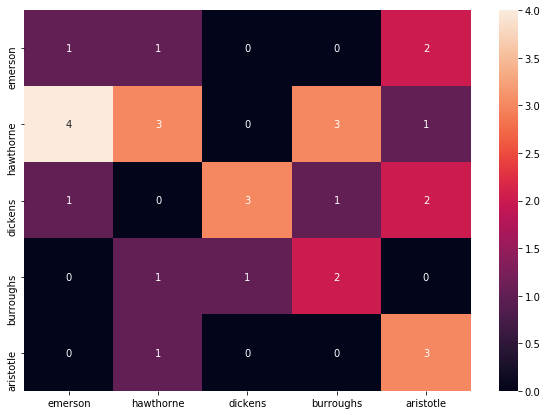

In [66]:
matrice_de_confusion(modele1.matrice_labels_test, y_pred_knn, modele1.auteurs)

Les résultats sont peu satisfaisants: sur 30 textes, seuls $2 + 3 + 1 + 3 + 3 = 12$ textes sont identifiés correctement. K-NN ne semble donc pas un bon algorithme pour mes données (certainement car la dimention d'attributs est très grande)

On va donc essayer l'algorithme Random Forrest Tree

### Random Tree Forrest

Random Forrest Tree n'est pas aussi simple à implémenter, vu qu'il a besoin de labels numériques: les prédictions qu'il va donner ne seront pas discrètes, il faudra donc arrondir chacune des prévisions à l'entier le plus proche, et on peut obtenir la prédiction d'auteur

#### Reformatation des labels pour Random Forrest Tree

On construit une fonction qui transforme le nom des auteurs en des entiers ordonnés. Ces entiers dépendent du nombre d'auteurs, mais pour 5 auteurs (notre cas), on a des entiers de 0 à 4.

In [67]:
def labels_random_forrest(labels, auteurs):
    label_random_forrest = []
    for label in labels:
        for auteur in auteurs:
            if label == auteur:
                label_random_forrest.append(auteurs.index(auteur))
    return np.array(label_random_forrest)

In [69]:
[x for x in enumerate(modele1.auteurs)]

[(0, 'emerson'),
 (1, 'hawthorne'),
 (2, 'dickens'),
 (3, 'burroughs'),
 (4, 'aristotle')]

Avec cette fonctrion on peut donc transformer les labels d'entrainement et de test

In [71]:
rf_train_labels = labels_random_forrest(modele1.matrice_labels_train, modele1.auteurs)

In [72]:
rf_test_labels = labels_random_forrest(modele1.matrice_labels_test, modele1.auteurs)

#### Random Forrest

On peut maintenant construire le classificateur Random Forrest. On crée une fonction qui simplifie cette tâche:

In [73]:
def random_forrest(estimateur, features, labels):
    regressor = RandomForestRegressor(n_estimators=estimateur, random_state=0)
    regressor.fit(features, labels)
    return regressor

Le choix du nombre d'estimateurs est un hyperparamètre à choisir. Après avoir testé plusieurs, 1500 semble obtenir la meilleure sollution

In [83]:
regressor = random_forrest(1500, modele1.matrice_features_train, rf_train_labels)

Comme mentionné précédemment, il faut maintenant arrondir les prédictions de Random Forrest Tree. On utilise la fonction suivante:

In [84]:
def rf_predict(regressor, test_features):
    y_prob = regressor.predict(test_features)
    
    y_pred = []
    for prob in y_prob:
        y_pred.append(round(prob))
        
    return y_pred

In [85]:
y_pred_rf = rf_predict(regressor, modele1.matrice_features_test)

Pour pouvoir visualiser la performance de la prédiction, on construit la matrice de confusion

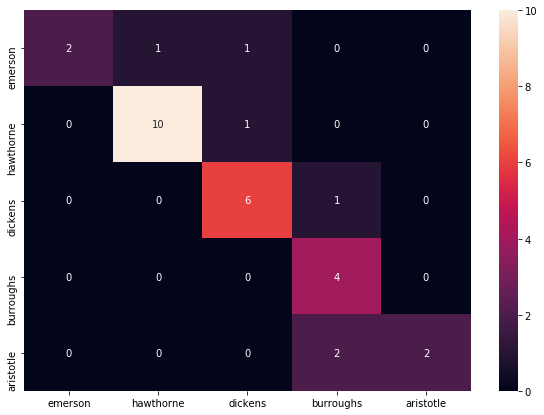

In [122]:
matrice_de_confusion(rf_test_labels, y_pred_rf, modele1.auteurs)

On voit que sur 30 textes testés, il y a $1 + 1 + 1 + 1 + 2 = 6$ textes mal classifiés. Cet algorihtme a une précision de 80%, ce qui est un résultat plutôt très satisfaisant. (beaucoup mieux que K-NN).

Avec uniquement des métriques de style, récupérables sur n'importe quel texte, notre algorithme a réussi à identifier avec une précision de 80% les auteurs des textes. Cela est un bon résultat, si on prend en compte que chaque auteur peut ne pas écrire tout le temps avec le même style. 

J'ai choisit les données de façon plus ou moins aléatoire, mais pour avoir de meilleurs résultats, il faudrait trouver une base de données plus consistente, qui soit représentative des différents styles d'un seul auteur. Mais c'est déjà un pas :)